<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/fixedL_transition_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes the connectivity change results from the seizure transition time frame of fixed length (L). This code generated the plots from Figure 3.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Mounted at /content/gdrive


Seizure lengths for all patients extracted from metadata:

In [2]:
lens = [138.94799999999998,
118.67600000000004,
81.62799999999993,
84.98400000000004,
93.65200000000004,
34.485839899999974,
91.15200000000004,
74.02200000000005,
357.606,
100.97800000000007,
221.58999999999992,
83.37,
92.26799999999992,
13.990000000000009,
108.10200000000009,
24.583999999999946,
505.45799999999997,
153.08105469999998,
20.696000000000026,
80.78710940000008,
24.583984399999963]

Plot seizure lengths:

Median: 91.15200000000004
Interquartile range: 74.02200000000005 118.67600000000004
Sigma = 114.20745952652496


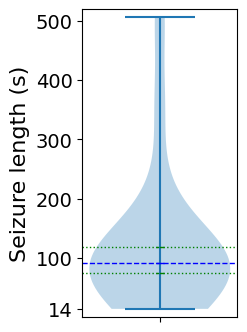

In [ ]:
x=np.array(lens)

median_x = np.median(lens)
q1_x = np.percentile(lens, 25, interpolation='midpoint')
q3_x = np.percentile(lens, 75, interpolation='midpoint')

print("Median:", median_x)
print("Interquartile range:", q1_x, q3_x)
print("Sigma =", np.std(x))

# Plot seizure lengths
# plt.hist(list(lens.values()), bins=21, histtype='stepfilled', color="grey")
plt.figure(figsize=(2,4))
plt.violinplot(x, showmeans=False, showmedians=False, showextrema=True)

# Add the median line
plt.scatter([1], [median_x], color='blue', marker='_', linewidth=1, label='Median')
plt.axhline(median_x, color='blue', linestyle='--', linewidth=1)

# Add the Q1 and Q3 lines
plt.scatter([1], [q1_x], color='green', marker='_', linewidth=1, label='Q1')
plt.axhline(q1_x, color='green', linestyle=':', linewidth=1)

plt.scatter([1], [q3_x], color='green', marker='_', linewidth=1, label='Q3')
plt.axhline(q3_x, color='green', linestyle=':', linewidth=1)

# Set y-ticks to include the min and max values
min_val = np.min(lens)
max_val = np.max(lens)

plt.yticks(np.append(plt.yticks()[0], [min_val]))
# Get default y-ticks and filter out 0
yticks = plt.yticks()[0]
yticks = yticks[yticks != 0]
plt.yticks(yticks)
plt.ylim(bottom=min_val-14, top=max_val+14)

plt.ylabel("Seizure length (s)", size=16)
plt.tick_params(axis='y', labelsize=14)
plt.xticks([1], [""], size=16)
plt.show()

Plot AUC distribution for fixed vs. relative time interval and check if there is a significant difference:

<ipython-input-4-60cf4f3779de>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(y="auc", x="tick", data=data, palette="colorblind", width=0.3, medianprops=dict(color="black", alpha=0.9))


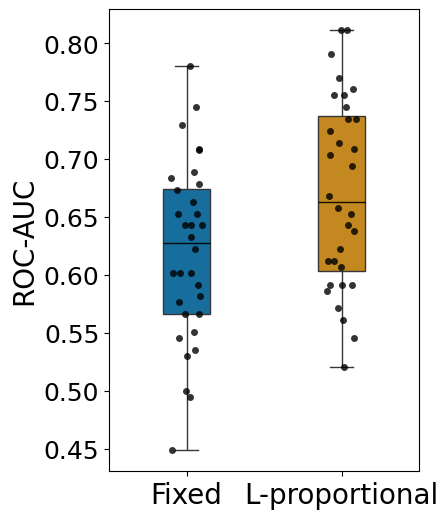

MannwhitneyuResult(statistic=341.5, pvalue=0.02242680598974323)
Max ROC-AUC for fixed: 0.7806122448979592


In [4]:
fixed = pd.read_excel(main_folder + "1cm_rocauc_results_ns27.xlsx")
relative = pd.read_excel(main_folder + "1cm_rocauc_results.xlsx")

relative = relative[relative["WOI"]=="NS"]

# Plot AUC distribution for fixed vs. relative time interval
fauc = list(fixed["AUC"])
rauc = list(relative["AUC"])
ticks = ["FIXED"]*len(fauc)+["RELATIVE"]*len(rauc)

data = {"auc":fauc+rauc,"tick":ticks}

plt.figure(figsize=(4, 6))

bp=sns.boxplot(y="auc", x="tick", data=data, palette="colorblind", width=0.3, medianprops=dict(color="black", alpha=0.9))
bp=sns.stripplot(y="auc", x="tick", data=data, jitter=True, dodge=True, marker="o", alpha=0.8, color="black")

plt.ylabel("ROC-AUC", size=20)
plt.xlabel("")
plt.yticks(fontsize=18)
plt.xticks([0,1], ["Fixed", "L-proportional"], fontsize=20)
plt.show()

# P value
t=0
if shapiro(fauc)[1]<0.05 and shapiro(rauc)[1]<0.05:
    t=ttest_ind(fauc,rauc)
else:
    t=mannwhitneyu(fauc,rauc,alternative="two-sided")
print(t)

print("Max ROC-AUC for fixed:", np.array(fauc).max())

Change in surgery outcome prediction ROC-AUC per individual analysis when considering L-proportional time window analysis relative to the fixed window analysis.

In [5]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
# cm_subs = {
#     "SC_R": "Real spectral coherence",
#     "SC_I": "Imaginary spectral coherence",
#     "PLV": "Phase-locking value",
#     "PLI": "Phase lag index",
#     "CC": "Cross-correlation",
#     "PAC": "PAC",
#     "PEC": "PEC"
# }

cm_subs = {
    "SC_R": "SCR",
    "SC_I": "SCI",
    "PLV": "PLV",
    "PLI": "PLI",
    "CC": "CC",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s


0.3418367346938776


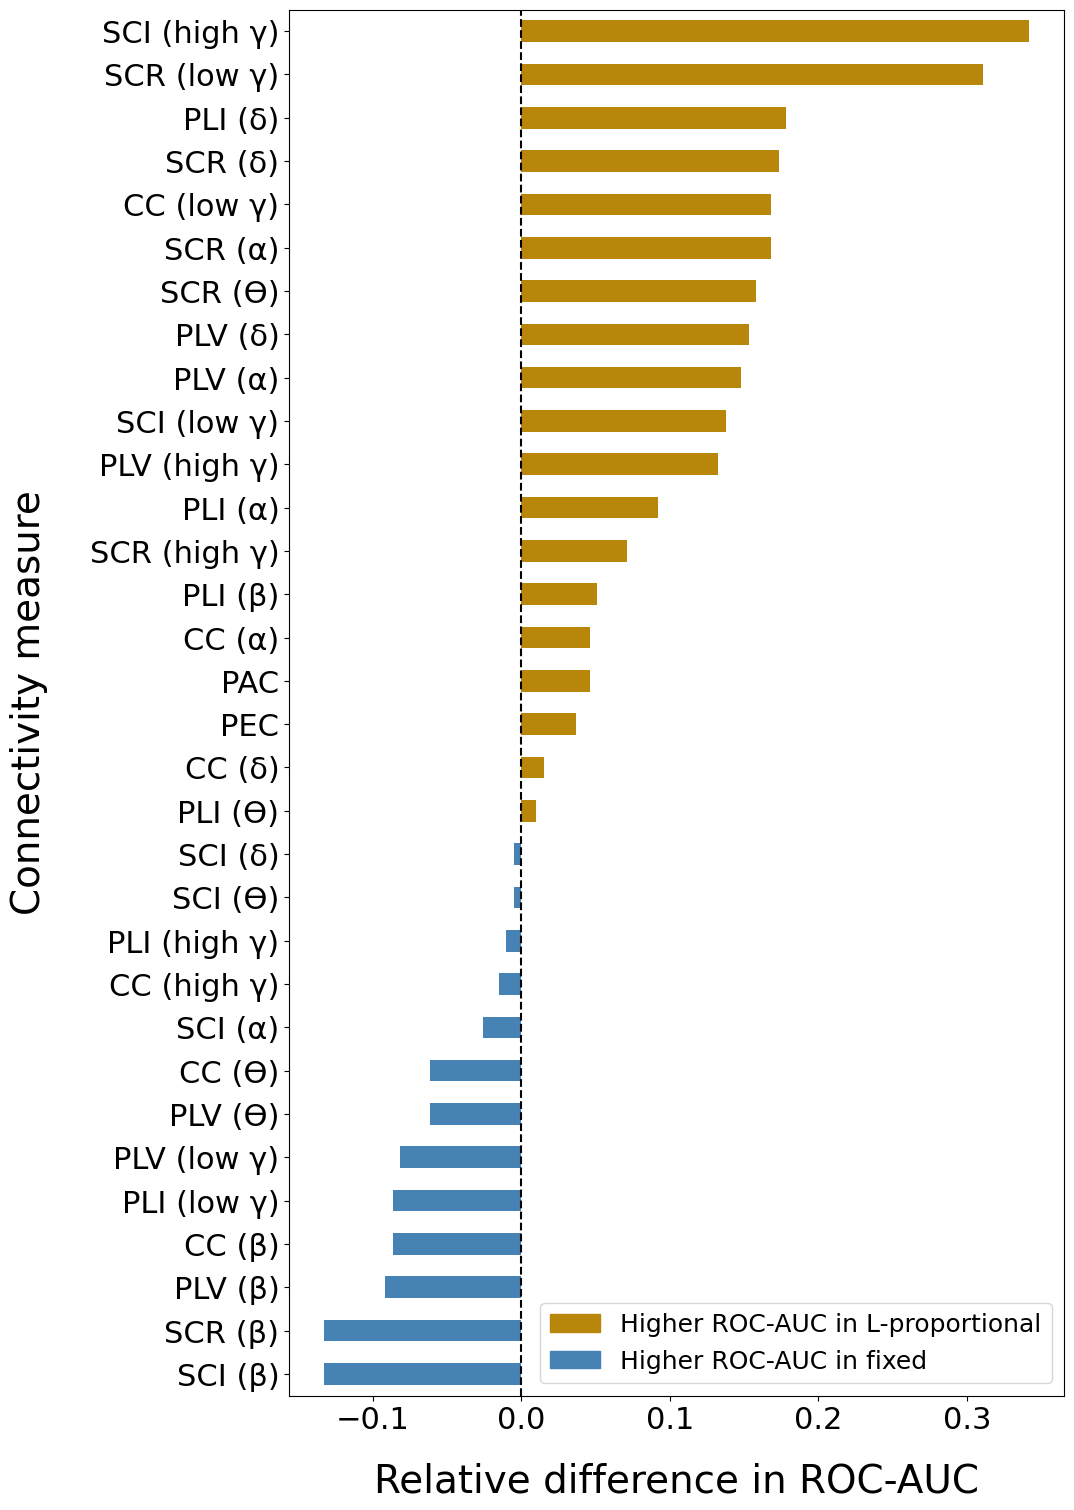

                     0
SCI (β)      -0.132653
SCR (β)      -0.132653
PLV (β)      -0.091837
CC (β)       -0.086735
PLI (low γ)  -0.086735
PLV (low γ)  -0.081633
PLV (ϴ)      -0.061224
CC (ϴ)       -0.061224
SCI (α)      -0.025510
CC (high γ)  -0.015306
PLI (high γ) -0.010204
SCI (ϴ)      -0.005102
SCI (δ)      -0.005102
PLI (ϴ)       0.010204
CC (δ)        0.015306
PEC           0.036565
PAC           0.045918
CC (α)        0.045918
PLI (β)       0.051020
SCR (high γ)  0.071429
PLI (α)       0.091837
PLV (high γ)  0.132653
SCI (low γ)   0.137755
PLV (α)       0.147959
PLV (δ)       0.153061
SCR (ϴ)       0.158163
SCR (α)       0.168367
CC (low γ)    0.168367
SCR (δ)       0.173469
PLI (δ)       0.178571
SCR (low γ)   0.311224
SCI (high γ)  0.341837


In [6]:
methods =list(fixed["CM"])
f = dict(zip(fixed["CM"], fixed["AUC"]))
r = dict(zip(relative["CM"], relative["AUC"]))

x = {} # loss/gain in AUC per method in relative in comparison to fixed
y={}
for method in methods:

    x[substitute_bands(substitute_cm(method))]=r[method]-f[method]
    y[method]=r[method]-f[method]

print(max(x.values()))

df = pd.DataFrame.from_dict(dict(sorted(x.items(),key = lambda k:k[1])), orient ='index')

plt.figure(figsize=(10,18))

df[0].plot(kind='barh', color=(df[0] > 0).map({True: 'darkgoldenrod', False: 'steelblue'}))

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='darkgoldenrod', label='Higher ROC-AUC in L-proportional')
patch2 = mpatches.Patch(color='steelblue', label='Higher ROC-AUC in fixed', )
plt.legend(handles=[patch1,patch2], loc='lower right', fontsize=18)
plt.xticks(size=22)
plt.yticks(size=22)
plt.xlabel("Relative difference in ROC-AUC", size=28, labelpad=20)
plt.ylabel("Connectivity measure", size=28, labelpad=30)
plt.axvline(x=0, ymin=0, color="black", ls="--")
plt.show()

print(df)